In [4]:
import librosa
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from fastdtw import fastdtw

# Load the DataFrame with labeled data
df = pd.read_csv('../data/dataframes/clean_labeled.csv')

# Define parameters
hop_length = 512
n_mels = 128
n_fft = 2048

# Function to extract Mel-spectrogram for a song
def extract_mel_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# Function to normalize Mel-spectrograms within each song
def normalize_spectrograms(spectrograms):
    mean = np.mean(spectrograms)
    std = np.std(spectrograms)
    normalized_spectrograms = (spectrograms - mean) / std
    return normalized_spectrograms


def find_sequence_with_target_bpm(beats, target_bpm, sr, min_sequence_length=2, bpm_tolerance=0.1):
    closest_sequence = None
    closest_sequence_error = float('inf')
    for i in range(len(beats) - min_sequence_length + 1):
        # Extract a sequence of at least minimum length specified
        sequence = beats[i:i + min_sequence_length]
        # Calculate the time duration of the sequence in seconds
        sequence_duration_seconds = librosa.frames_to_time(sequence[-1] - sequence[0], sr=sr)
        # Calculate the sequence tempo in BPM
        sequence_tempo = 60 / sequence_duration_seconds
        # Check if this sequence has a tempo estimate within the tolerance range of the target BPM
        if abs(sequence_tempo - target_bpm) <= bpm_tolerance:
            # Calculate the absolute error between the sequence tempo and the target BPM
            sequence_error = abs(sequence_tempo - target_bpm)
            # Check if this sequence has a closer tempo estimate
            if sequence_error < closest_sequence_error:
                closest_sequence_error = sequence_error
                closest_sequence = sequence
    return closest_sequence

# Function to generate a measure grid based on tempo and time signature
def create_measure_grid(bpm, sr, closest_sequence, duration, time_signature=4):
    """Quantize beats and create measure grid in frame units."""
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4
    beat_interval = 60.0 / bpm
    center_measure = librosa.frames_to_time(closest_sequence[0], sr=sr, hop_length=hop_length)
    measures_to_center = int(np.floor(center_measure / (beat_interval * beats_per_measure)))
    first_measure_time = center_measure - (measures_to_center * beat_interval * beats_per_measure)
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))
    beat_grid = beat_grid[beat_grid >= 0]
    beat_grid = beat_grid[beat_grid <= duration]
    measure_grid = beat_grid[::beats_per_measure]
    measure_length = beat_interval * beats_per_measure
    # Add 0 to the start of the measure grid
    measure_grid = np.insert(measure_grid, 0, 0)  
    # Append the duration to the end of the measure grid
    measure_grid = np.append(measure_grid, duration) 
    # Convert measure grid to frame units
    measure_grid_frames = librosa.time_to_frames(measure_grid, sr=sr, hop_length=hop_length)   
    return measure_grid_frames

# Function to generate label sequence from the labeled dataset
def generate_label_sequence(df, total_frames):
    label_sequence = np.full(total_frames, 'non-mix-in', dtype=object)
    
    for index, row in df.iterrows():
        start_frame = row['start_frame']
        end_frame = row['end_frame']
        label = row['label']
        label_sequence[start_frame:end_frame] = 'chorus' if label == 'chorus' else 'other'
    
    return label_sequence

# Function to apply DTW to align label sequence with the measure grid
def align_labels_with_grid(label_sequence, measure_grid):
    # Use DTW to align label sequence with measure grid
    _, path = fastdtw(np.arange(len(measure_grid)).reshape(-1, 1), np.arange(len(label_sequence)).reshape(-1, 1))
    
    # Create aligned label sequence
    aligned_labels = np.array([label_sequence[path[i, 1]] for i in range(len(measure_grid))])
    
    return aligned_labels

# Function to segment normalized Mel-spectrograms into labeled measures
def segment_spectrograms(normalized_spectrogram, measure_grid):
    measures = []
    for i in range(len(measure_grid) - 1):
        start_frame = measure_grid[i]
        end_frame = measure_grid[i + 1]
        measure = normalized_spectrogram[:, start_frame:end_frame]
        measures.append(measure)
    
    return measures

In [14]:
df['sp_time_signature'].value_counts()

sp_time_signature
4.0    1717
3.0      22
0.0       7
5.0       5
Name: count, dtype: int64

In [ ]:
# Iterate through the DataFrame and prepare data for each song
for _, group in df.groupby('SongID'):
    audio_path = group['FilePath'].values[0]  # Assumes the audio file path is the same for each song
    
    y, sr = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr, hop_length=512)
    
    # Extract Mel-spectrogram
    spectrogram = extract_mel_spectrogram(audio_path)
    
    # Normalize Mel-spectrogram
    normalized_spectrogram = normalize_spectrograms(spectrogram)
    
    # Extract tempo, beat  frames
    C = np.abs(librosa.cqt(y=y, sr=sr))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    if not pd.isna(group['sp_tempo'].values[0]):
        tempo = group['sp_tempo'].values[0]
        
    
    # Generate measure grid based on tempo and time signature
    tempo = group['Tempo'].values[0]  # Assumes tempo is the same for each song
    time_signature = group['sp_time_signature'].values[0]  # Assumes time signature is the same for each song
    onset_frames = group['OnsetFrames'].values  # Assumes you have onset frames for each song
    measure_grid = generate_measure_grid(tempo, time_signature, onset_frames)
    
    # Generate label sequence
    label_sequence = generate_label_sequence(group, len(normalized_spectrogram[0]))
    
    # Align label sequence with measure grid
    aligned_labels = align_labels_with_grid(label_sequence, measure_grid)
    
    # Segment normalized Mel-spectrogram into labeled measures
    measures = segment_spectrograms(normalized_spectrogram, measure_grid)
    
    # Now you can use 'measures' and 'aligned_labels' for training your CRNN model

In [62]:
import librosa
import numpy as np
from scipy.signal import find_peaks

audio_file = r"..\data\audio_files\processed\2.mp3"
# Define parameters
hop_length = 512
n_mels = 128
n_fft = 2048

y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr, hop_length=hop_length)
# Calculate onset strength envelope, tempo, beat event locations
C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

def create_measure_grid(duration, closest_sequence, tempo, sp_tempo=None, sr=sr):
    """Quantize beats and create measure grid in frame units."""
    if sp_tempo is not None:
        bpm = sp_tempo
    elif tempo is not None:
        bpm = tempo
    else:
        raise ValueError("Either 'tempo' or 'sp_tempo' must be provided.")
    
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4
    beat_interval = 60.0 / bpm
    center_measure = librosa.frames_to_time(closest_sequence[0], sr=sr, hop_length=hop_length)
    measures_to_center = int(np.floor(center_measure / (beat_interval * beats_per_measure)))
    first_measure_time = center_measure - (measures_to_center * beat_interval * beats_per_measure)
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))
    beat_grid = beat_grid[beat_grid >= 0]
    beat_grid = beat_grid[beat_grid <= duration]
    measure_grid = beat_grid[::beats_per_measure]
    measure_length = beat_interval * beats_per_measure

    # Add 0 to the start of the measure grid
    measure_grid = np.insert(measure_grid, 0, 0)
    
    # Append the duration to the end of the measure grid
    measure_grid = np.append(measure_grid, duration)
    
    # Convert measure grid to frame units
    measure_grid_frames = librosa.time_to_frames(measure_grid, sr=sr, hop_length=hop_length)
    
    return measure_grid_frames


def find_sequence_with_target_bpm(beats, target_bpm, sr=sr, min_sequence_length=2, bpm_tolerance=0.1):
    closest_sequence = None
    closest_sequence_error = float('inf')

    for i in range(len(beats) - min_sequence_length + 1):
        # Extract a sequence of at least minimum length specified
        sequence = beats[i:i + min_sequence_length]

        # Calculate the time duration of the sequence in seconds
        sequence_duration_seconds = librosa.frames_to_time(sequence[-1] - sequence[0], sr=sr)

        # Calculate the sequence tempo in BPM
        sequence_tempo = 60 / sequence_duration_seconds

        # Check if this sequence has a tempo estimate within the tolerance range of the target BPM
        if abs(sequence_tempo - target_bpm) <= bpm_tolerance:
            # Calculate the absolute error between the sequence tempo and the target BPM
            sequence_error = abs(sequence_tempo - target_bpm)

            # Check if this sequence has a closer tempo estimate
            if sequence_error < closest_sequence_error:
                closest_sequence_error = sequence_error
                closest_sequence = sequence

    return closest_sequence

closest_sequence = find_sequence_with_target_bpm(beats, tempo)
measure_grid = create_measure_grid(duration, closest_sequence, tempo=tempo, sp_tempo=None)
measure_grid

[0,
 1154,
 93314,
 185474,
 277634,
 369794,
 461954,
 554114,
 646274,
 738434,
 830594,
 922754,
 1014914,
 1107074,
 1199234,
 1291394,
 1383554,
 1475714,
 1567874,
 1660034,
 1752194,
 1844354,
 1936514,
 2028674,
 2120834,
 2212994,
 2305154,
 2397314,
 2489474,
 2581634,
 2673794,
 2765954,
 2858114,
 2950274,
 3042434,
 3134594,
 3226754,
 3318914,
 3411074,
 3503234,
 3595394,
 3687554,
 3779714,
 3871874,
 3964034,
 4056194,
 4148354,
 4240514,
 4332674,
 4424834,
 4516994,
 4609154,
 4701314,
 4793474,
 4885634,
 4977794,
 5069954,
 5162114,
 5254274,
 5346434,
 5438594,
 5530754,
 5622914,
 5715074,
 5807234,
 5899394,
 5991554,
 6083714,
 6175874,
 6268034,
 6360194,
 6452354,
 6544514,
 6636674,
 6728834,
 6820994,
 6913154,
 7005314,
 7097474,
 7189634,
 7281794,
 7373954,
 7466114,
 7558274,
 7650434,
 7742594,
 7834754,
 7926914,
 8019074,
 8111234,
 8203394,
 8295554,
 8387714,
 8479874,
 8572034,
 8664194,
 8756354,
 8848514,
 8940674,
 9032834,
 9124994,
 9217154,


In [80]:
import librosa
import numpy as np

def create_measure_grid(duration, closest_sequence, tempo, sp_tempo=None, sr=sr):
    """Quantize beats and create measure grid in frame units."""
    if sp_tempo is not None:
        bpm = sp_tempo
    elif tempo is not None:
        bpm = tempo
    else:
        raise ValueError("Either 'tempo' or 'sp_tempo' must be provided.")
    
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4
    beat_interval = 60.0 / bpm
    center_measure = librosa.frames_to_time(closest_sequence[0], sr=sr, hop_length=hop_length)
    measures_to_center = int(np.floor(center_measure / (beat_interval * beats_per_measure)))
    first_measure_time = center_measure - (measures_to_center * beat_interval * beats_per_measure)
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))
    beat_grid = beat_grid[beat_grid >= 0]
    beat_grid = beat_grid[beat_grid <= duration]
    measure_grid = beat_grid[::beats_per_measure]
    measure_length = beat_interval * beats_per_measure

    # Add 0 to the start of the measure grid
    measure_grid = np.insert(measure_grid, 0, 0)
    
    # Append the duration to the end of the measure grid
    measure_grid = np.append(measure_grid, duration)
    
    # Convert measure grid to frame units
    measure_grid_frames = librosa.time_to_frames(measure_grid, sr=sr, hop_length=hop_length)
    
    return measure_grid_frames

measure_grid= create_measure_grid(duration, closest_sequence, tempo=tempo, sp_tempo=None)


array([  0.        ,   0.30933333,   1.74933333,   3.66933333,
         5.58933333,   7.50933333,   9.42933333,  11.34933333,
        13.26933333,  15.18933333,  17.10933333,  19.02933333,
        20.94933333,  22.86933333,  24.78933333,  26.70933333,
        28.62933333,  30.54933333,  32.46933333,  34.38933333,
        36.30933333,  38.22933333,  40.14933333,  42.06933333,
        43.98933333,  45.90933333,  47.82933333,  49.74933333,
        51.66933333,  53.58933333,  55.50933333,  57.42933333,
        59.34933333,  61.26933333,  63.18933333,  65.10933333,
        67.02933333,  68.94933333,  70.86933333,  72.78933333,
        74.70933333,  76.62933333,  78.54933333,  80.46933333,
        82.38933333,  84.30933333,  86.22933333,  88.14933333,
        90.06933333,  91.98933333,  93.90933333,  95.82933333,
        97.74933333,  99.66933333, 101.58933333, 103.50933333,
       105.42933333, 107.34933333, 109.26933333, 111.18933333,
       113.10933333, 115.02933333, 116.94933333, 118.86

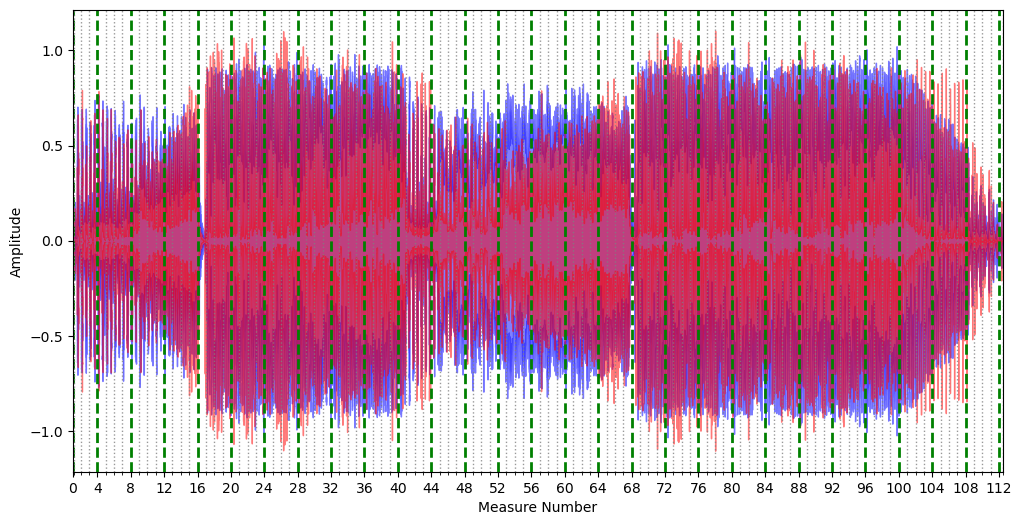

In [81]:
def apply_measure_grid(ax, measure_grid):
    """
    This function takes an axis object and applies measure grid lines,
    sets x-ticks to measure start times for every fourth measure starting from measure 0,
    labels them with measure numbers, and applies sub-ticks for intermediate measure times.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis object to modify.
    measure_grid (list or array): The list or array of measure start times in seconds.
    """
    measure_numbers = np.arange(len(measure_grid))
    # Adjust the list to start from measure 0 and get every fourth measure
    major_measure_indices = [i for i, measure_num in enumerate(measure_numbers) if (measure_num) % 4 == 0]
    major_measures = [measure_grid[i] for i in major_measure_indices]
    major_labels = [measure_numbers[i] for i in major_measure_indices]
    
    # Set major x-axis ticks and labels (for measure 0 and every fourth measure after)
    ax.set_xticks(major_measures, minor=False)
    ax.set_xticklabels(major_labels, minor=False)

    # Set minor x-axis ticks (for intermediate measures)
    minor_measures = [measure for i, measure in enumerate(measure_grid) if i not in major_measure_indices]
    ax.set_xticks(minor_measures, minor=True)
    
    # Overlay the major measure grid lines on the plot (for measure 0 and every fourth measure after)
    for measure_time in major_measures:
        ax.axvline(x=measure_time, color='green', linestyle='--', linewidth=2)  # Adjusted linewidth for major ticks
    
    # Overlay the minor measure grid lines on the plot (for intermediate measures)
    for measure_time in minor_measures:
        ax.axvline(x=measure_time, color='grey', linestyle=':', linewidth=1, alpha=0.8)  # Adjusted linewidth for minor ticks
    
    ax.set_xlabel('Measure Number')

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the harmonic and percussive components
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, color='b', alpha=0.5, ax=ax, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set_xlim([0, duration])   
ax.set_ylabel('Amplitude')
# Apply the measure grid to the axis
apply_measure_grid(ax, measure_grid)


# Show the plot
plt.show()

In [37]:
import librosa
import numpy as np
from scipy.signal import find_peaks


audio_file = r"..\data\audio_files\processed\2.mp3"
y, sr = librosa.load(audio_path, sr=None)
C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

# Find stable onsets (peaks) using the adjusted threshold
peaks, _ = find_peaks(onset_env, height=.8)

# Calculate IOIs
iois = np.diff(peaks)
mean_ioi = np.mean(iois)
bpm = 60 / mean_ioi

print(tempo)

125.0


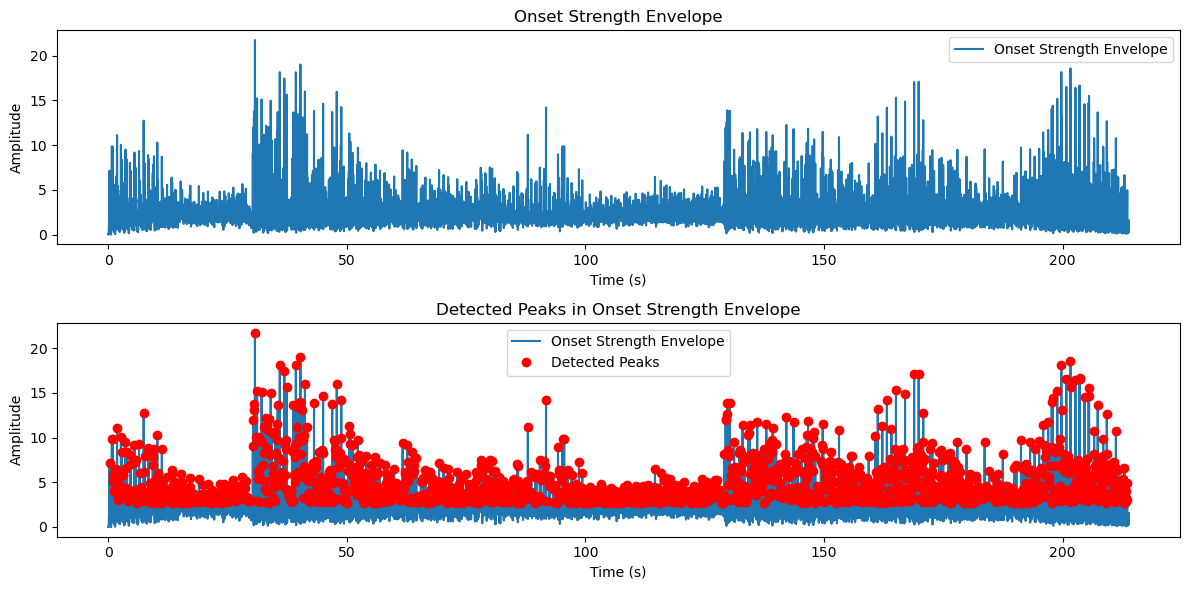

In [33]:
# Plot the onset envelope
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset Strength Envelope')
plt.title('Onset Strength Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Plot the detected peaks
plt.subplot(2, 1, 2)
plt.plot(librosa.times_like(onset_env), onset_env, label='Onset Strength Envelope')
plt.plot(librosa.times_like(onset_env)[peaks], onset_env[peaks], 'ro', label='Detected Peaks')
plt.title('Detected Peaks in Onset Strength Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
peaks

array([  13,   34,   40, ..., 9199, 9203, 9205], dtype=int64)

In [5]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the DataFrame 
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
hop_length = 512
sr = 22050
n_mels = 128
n_fft = 2048
save_dir = '../data/spectrogram_frames/' # Directory to save labeled spectrogram frames


# Function to label the spectrogram frames
def label_spectrogram_frames(S_dB, start_frame, end_frame, label):
    # Create an array to store the labels for each frame
    labels = np.full_like(S_dB[0], label, dtype=object)
    
    # Mark the frames between start_frame and end_frame with the label
    labels[start_frame:end_frame] = 'chorus' if label == 'chorus' else 'other'
    
    return labels


# Function to normalize a spectrogram
def normalize_spectrogram(spectrogram):
    mean = np.mean(spectrogram)
    std = np.std(spectrogram)
    normalized_spectrogram = (spectrogram - mean) / std
    return normalized_spectrogram
    

# Iterate through unique SongIDs in the DataFrame
unique_song_ids = df['SongID'].unique()
for song_id in tqdm(unique_song_ids, desc="Processing..."):
    # Filter DataFrame for the current SongID
    song_df = df[df['SongID'] == song_id]
    
    # Extract relevant data (assuming they are the same for all frames of the same song)
    audio_path = song_df.iloc[0]['FilePath']  # Get the first row's audio path
    start_frame = song_df.iloc[0]['start_frame']  # Get the first row's start_frame
    end_frame = song_df.iloc[0]['end_frame']  # Get the first row's end_frame
    label = song_df.iloc[0]['label']  # Get the first row's label
    
    # Load the audio (assuming audio is the same for all frames of the same song)
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Calculate the spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Normalize the spectrogram
    normalized_spectrogram = normalize_spectrogram(S_dB)
    
    # Label the spectrogram frames (assuming labels are the same for all frames of the same song)
    spectrogram_labels = label_spectrogram_frames(normalized_spectrogram, start_frame, end_frame, label)
    
    # Create a directory for the current song if it doesn't exist
    song_dir = os.path.join(save_dir, str(song_id))
    os.makedirs(song_dir, exist_ok=True)

    # Save each frame as an image with its label
    for frame_num, label in enumerate(spectrogram_labels):
        filename = f'{song_id}_{frame_num}_spectrogram.png'
        filepath = os.path.join(song_dir, filename)
        
        # Save the frame as an image using matplotlib or another image library
        # You can use matplotlib to create and save the images
        plt.figure(figsize=(10, 4))
        plt.imshow(S_dB[:, frame_num], cmap='viridis', origin='lower')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Label: {label}')
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
        plt.close()

Processing spectrograms...: 100%|██████████| 332/332 [11:49<00:00,  2.14s/it]
